<a href="https://colab.research.google.com/github/gcfer/VAEs/blob/main/vae_mnist_custom_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with MNIST digits using a custom layer for the custom loss

##### Copyright 2020

Licensed under the MIT License.

In [ ]:
# Copyright 2020 Guido Carlo Ferrante
#
# Licensed under the MIT License. 
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# ==============================================================================

## Overview

In this notebook, we want to estimate the distribution of digits from MNIST. To start with, we just want to estimate the distribution of the “0” digit.

In [ ]:
# Import tensorflow
%tensorflow_version 2.x
import tensorflow as tf
# Import MNIST
mnist = tf.keras.datasets.mnist
# mnist = tf.keras.datasets.fashion_mnist
# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)
# Import other libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

/device:GPU:0


In [ ]:
# training pairs, validation pairs: each pair is (data, label)
(x_t, y_t), (x_v, y_v) = mnist.load_data()
n_t_samples = x_t.shape[0] # number of training samples
n_x = x_t[0].shape[0]
n_y = x_t[0].shape[1]
n_pixels = n_x * n_y

# normalize the data
x_t = x_t.astype(np.float32)
x_v = x_v.astype(np.float32)

x_t = x_t/255.0
x_v = x_v/255.0

print(x_t.shape)
print(y_t.shape)
print(n_pixels)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
784


We can take a look at one sample.

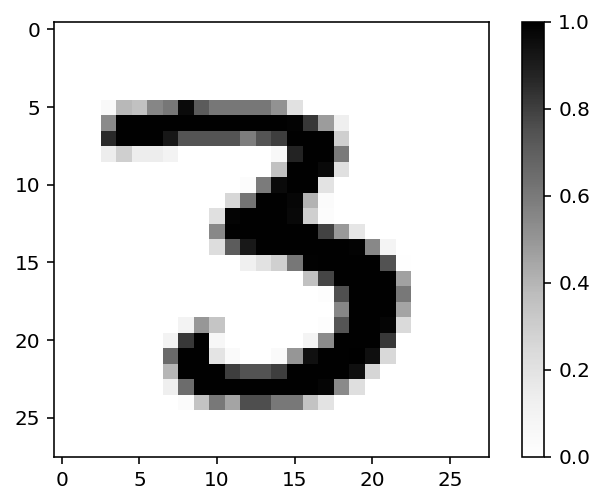

In [ ]:
plt.imshow(x_t[12], cmap=plt.get_cmap('Greys'))
plt.colorbar();

In [ ]:
print(y_t[12])

3


## VAE

In [ ]:
latent_dim = 2
interm_dim = 128

# Sampling layer
class Sampling(tf.keras.layers.Layer):
  """Uses (z_mu, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mu, z_log_var = inputs
    batch = tf.shape(z_mu)[0]
    dim = tf.shape(z_mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mu + tf.math.exp(0.5 * z_log_var) * epsilon

# encoder
encoder_input = tf.keras.layers.Input(shape=(n_pixels,))
encoder_interm = tf.keras.layers.Dense(interm_dim, activation=tf.nn.elu, name='enc_interm')(encoder_input)

z_mu = tf.keras.layers.Dense(latent_dim, activation=tf.nn.elu, name='mean')(encoder_interm)
z_log_var = tf.keras.layers.Dense(latent_dim, activation=tf.nn.elu, name='var')(encoder_interm)
# z_sample = Sampling()((z_mu, z_log_var))
z_sample = tf.keras.layers.Lambda(lambda input: input[0] + tf.math.exp(0.5 * input[1]) * tf.random.normal(shape=tf.shape(input[0])))([z_mu, z_log_var])

encoder = tf.keras.Model(encoder_input, [z_sample, z_mu, z_log_var])

# decoder 
decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
decoder_interm = tf.keras.layers.Dense(interm_dim, activation=tf.nn.elu, name='dec_interm')(decoder_input)
decoder_output = tf.keras.layers.Dense(n_pixels, activation='sigmoid', name='dec_output')(decoder_interm)

decoder = tf.keras.Model(decoder_input, decoder_output)
z_decoded = decoder(z_sample)

# custom layer to output the custom loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_log_var):
        x = tf.reshape(x, [-1])
        z_decoded = tf.reshape(z_decoded, [-1])
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded) * 784.0
        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var), axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_log_var = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
loss = CustomVariationalLayer()([encoder_input, z_decoded, z_mu, z_log_var])

vae = tf.keras.Model(encoder_input, loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=None)

At this point, we can fit the model over the data.

In [ ]:
n_epochs = 25
x_t_reshaped = np.reshape(x_t, (x_t.shape[0], n_pixels))

vae.fit(x_t_reshaped, None, batch_size=128, epochs=n_epochs)

Epoch 1/25
469/469 [==============================] - 1s 2ms/step - loss: 212.9692
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 185.8578
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 181.3383
Epoch 4/25
469/469 [==============================] - 1s 2ms/step - loss: 178.8365
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 177.2479
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 176.1019
Epoch 7/25
469/469 [==============================] - 1s 2ms/step - loss: 175.3227
Epoch 8/25
469/469 [==============================] - 1s 2ms/step - loss: 174.7006
Epoch 9/25
469/469 [==============================] - 1s 2ms/step - loss: 174.1891
Epoch 10/25
469/469 [==============================] - 1s 2ms/step - loss: 173.8970
Epoch 11/25
469/469 [==============================] - 1s 2ms/step - loss: 173.4646
Epoch 12/25
469/469 [==============================] - 1s 2ms/step - loss: 173.1637
E

After fitting the model, let's plot the manifold.

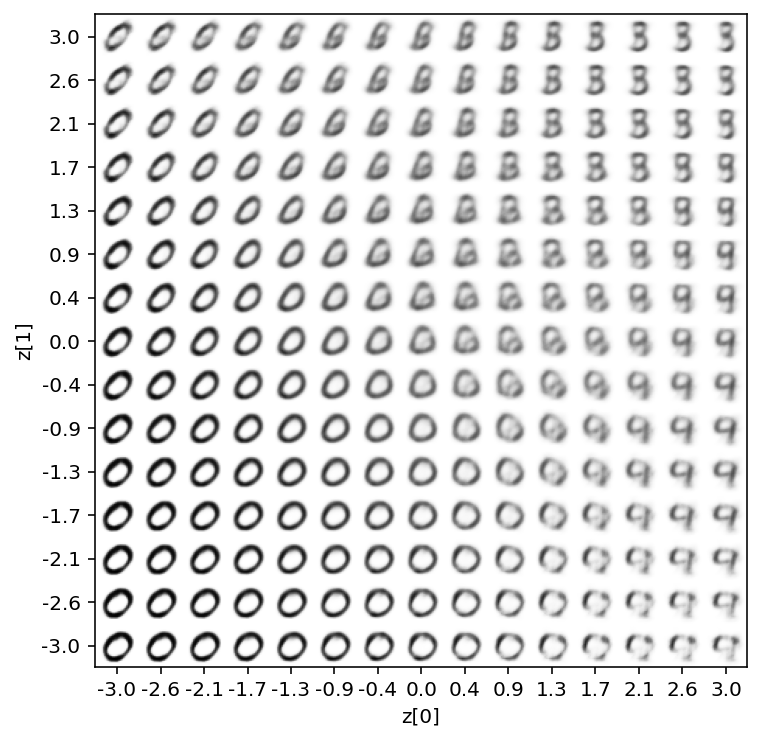

In [ ]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 15
    digit_size = 28
    scale = 3.0
    figsize = 6
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys")
    plt.show()


plot_latent(encoder, decoder)

Let's plot the clusters.

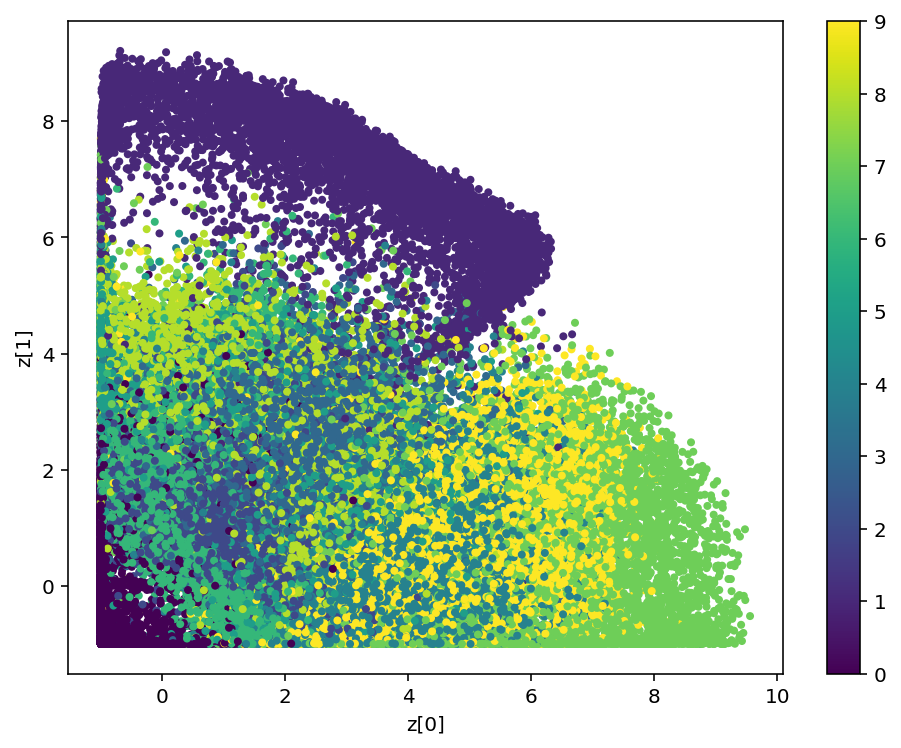

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_sample, z_mu, z_log_var = encoder.predict(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=labels, s=9)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_t_reshaped, y_t)

We can also use the decoder as a generative model.

In [ ]:
random_digit = decoder.predict(np.array([[8.5, 0.75]]))

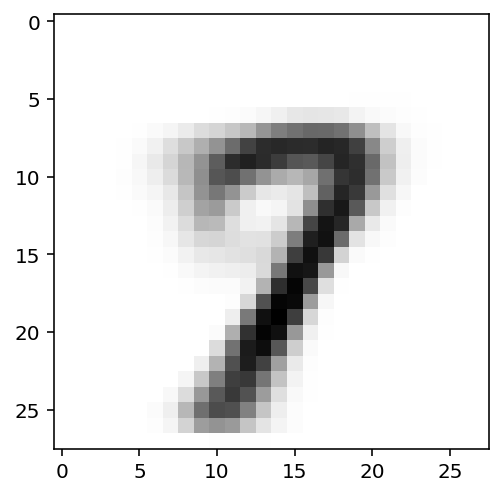

In [ ]:
digit_size = x_t.shape[1]
plt.imshow(random_digit[0].reshape(digit_size, digit_size), cmap='gray_r');